In [27]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import snapatac2 as snap
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import pyranges as pr
import os
import warnings
import requests
from tqdm import tqdm
from Bio.SeqIO.QualityIO import FastqGeneralIterator
plt.rcdefaults()

import sys
sys.path.append('/scratch/eli')
from perturbseq import *

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
# plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# relies on output of cropseq_call_guides.py and cellranger output

def cut_qc_metrics_by_called(sample_name, figsize = (12,2.5), mode = 'gex', savefig = None, downsampled = False):
    
    id_files = [file for file in os.scandir("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_outs") if "called_ids" in file.name] if not downsampled else [file for file in os.scandir("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_downsampled") if "called_ids" in file.name]
    called_ids = pd.read_csv([f for f in id_files if sample_name in f.name][0]).reset_index().groupby("CB").UMI.count().to_frame("n_guides")
    called_ids.index = called_ids.index.map(lambda cb: cb + "-1")

    if mode == 'gex':

        adata_files = [file for file in os.scandir("/data/norman/eli/T7/202404_SIRLOIN_multiome/") if sample_name in file.name]
        adata_path = adata_files[0].path + '/outs/filtered_feature_bc_matrix.h5'

        adata = sc.read_10x_h5(adata_path)
        adata.var_names_make_unique()
        adata.var["mito"] = adata.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(adata, inplace=True, qc_vars = ["mito"])
        
        merge = adata.obs.join(called_ids, how = 'left')
        merge["Assigned"] = merge["n_guides"].fillna(0).map(lambda n: n > 0)
        merge.drop_duplicates(inplace = True)

        fig, ax = plt.subplots(1, 3, figsize=figsize)
        sns.histplot(data = merge, x = 'log1p_total_counts', kde = True, hue = 'Assigned', ax = ax[0])
        sns.histplot(data = merge, x = 'log1p_n_genes_by_counts', kde = True, hue = 'Assigned', ax = ax[1])
        sns.histplot(data = merge, x = 'pct_counts_mito', kde = True, hue = 'Assigned', ax = ax[2])
        ax[0].axvline(6, color = 'red', linestyle = '--')
        ax[1].axvline(6, color = 'red', linestyle = '--')
        ax[2].set_xlim([-2,50])

        ax[0].set_xlabel("log1p(total UMI)")
        ax[1].set_xlabel("log1p(unique genes)")
        ax[2].set_xlabel("UMIs from mitochondrial genes (%)")
        for i in range(3):
            ax[i].set_ylabel("Number of cells")

        # fig.suptitle(f"{sample_name} GEX QC metrics by guide call")
        fig.tight_layout()
        if savefig is not None:
            plt.savefig(savefig)
        fig.show()

    elif mode == 'atac':

        adata_files = [file for file in os.scandir("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files") if sample_name in file.name and 'preprocessed_atac' in file.name]
        adata = snap.read(adata_files[0].path, backed = None)
        merge = adata.obs.join(called_ids, how = 'left')
        merge["Assigned"] = merge["n_guides"].fillna(0).map(lambda n: n > 0)
        merge.drop_duplicates(inplace = True)
        adata.obs = merge
        
        fdist_assigned = snap.metrics.frag_size_distr(adata[adata.obs.Assigned], inplace = False)
        fdist_unassigned = snap.metrics.frag_size_distr(adata[~adata.obs.Assigned], inplace = False)

        fig, ax = plt.subplots(1, 3, figsize=figsize)
        sns.histplot(data = merge, x = 'n_fragment', kde = True, hue = 'Assigned', ax = ax[0])
        ax[0].set_xlim([0,6e4])
        sns.histplot(data = merge, x = 'tsse', kde = True, hue = 'Assigned', ax = ax[1])
        ax[0].axvline(1000, color = 'red', linestyle = '--')
        ax[2].bar(np.arange(len(fdist_unassigned) - 1), fdist_unassigned[1:] / 1e5, alpha = 0.5, label = 'False', rasterized = True)
        ax[2].plot(np.arange(len(fdist_unassigned) - 1), fdist_unassigned[1:] / 1e5, alpha = 0.8)
        ax[2].bar(np.arange(len(fdist_assigned) - 1), fdist_assigned[1:] / 1e5, alpha = 0.5, label = 'True', rasterized = True)
        ax[2].plot(np.arange(len(fdist_assigned) - 1), fdist_assigned[1:] / 1e5, alpha = 0.8)
        # ax[2].legend()
        
        ax[0].set_xlabel("Number of unique fragments")
        ax[1].set_xlabel("TSS enrichment")
        ax[2].set_xlabel("Fragment size (bp)")
        ax[0].set_ylabel("Number of cells")
        ax[1].set_ylabel("Number of cells")
        ax[2].set_ylabel("Fragments x 1e5")

        # fig.suptitle(f"{sample_name} ATAC QC metrics by guide call")
        fig.tight_layout()
        if savefig is not None:
            plt.savefig(savefig)
        fig.show()

    return merge

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
2024-10-14 10:34:53 - INFO - maxp pruned
2024-10-14 10:34:53 - INFO - cmap pruned
2024-10-14 10:34:53 - INFO - post pruned
2024-10-14 10:34:53 - INFO - FFTM dropped
2024-10-14 10:34:53 - INFO - GPOS pruned
2024-10-14 10:34:53 - INFO - GSUB pruned
2024-10-14 10:34:53 - INFO - name pruned
2024-10-14 10:34:53 - INFO - glyf pruned
2024-10-14 10:34:53 - INFO - Added gid0 to subset
2024-10-14 10:34:53 - INFO - Added first four glyphs to subset
2024-10-14 10:34:53 - INFO - Closing glyph list over 'GSUB': 42 glyphs before
2024-10-14 10:34:53 - INFO - Glyph names: ['.notdef', '.null', 'A', 'F', 'I', 'M', 'N', 'T', 'U', 'a',

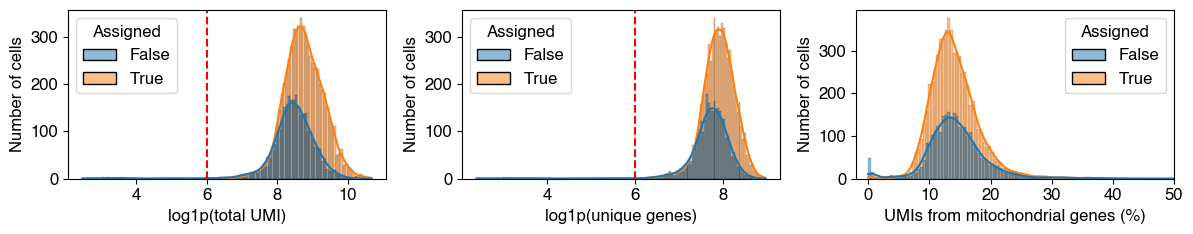

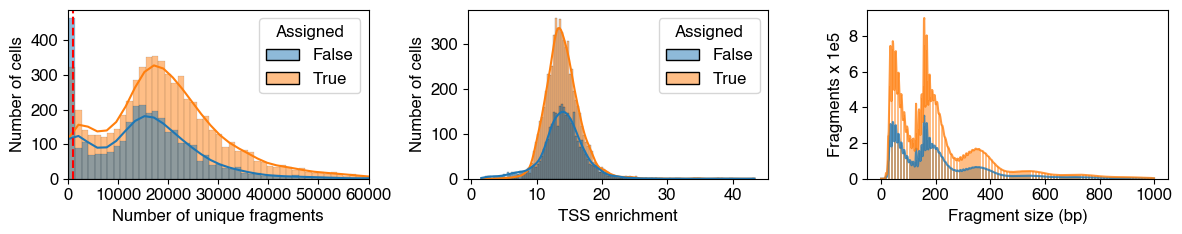

In [6]:
gexqc_040 = cut_qc_metrics_by_called("Lane1_040", savefig = 'outs/S3d_040_gexqc.pdf')
atacqc_040 = cut_qc_metrics_by_called("Lane1_040", mode = 'atac', savefig = 'outs/S3e_040_atacqc.pdf')
qc040 = gexqc_040.join(atacqc_040.drop(["n_guides", "Assigned"], axis = 1), how = 'inner')
qc040.n_fragment = qc040.n_fragment.astype(int)

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
2024-10-14 10:28:54 - INFO - maxp pruned
2024-10-14 10:28:54 - INFO - cmap pruned
2024-10-14 10:28:54 - INFO - post pruned
2024-10-14 10:28:54 - INFO - FFTM dropped
2024-10-14 10:28:54 - INFO - GPOS pruned
2024-10-14 10:28:54 - INFO - GSUB pruned
2024-10-14 10:28:54 - INFO - name pruned
2024-10-14 10:28:54 - INFO - glyf pruned
2024-10-14 10:28:54 - INFO - Added gid0 to subset
2024-10-14 10:28:54 - INFO - Added first four glyphs to subset
2024-10-14 10:28:54 - INFO - Closing glyph list over 'GSUB': 42 glyphs before
2024-10-14 10:28:54 - INFO - Glyph names: ['.notdef', '.null', 'A', 'F', 'I', 'M', 'N', 'T', 'U', 'a',

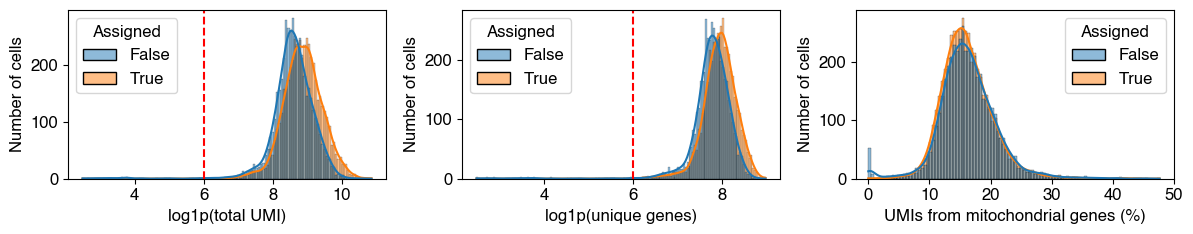

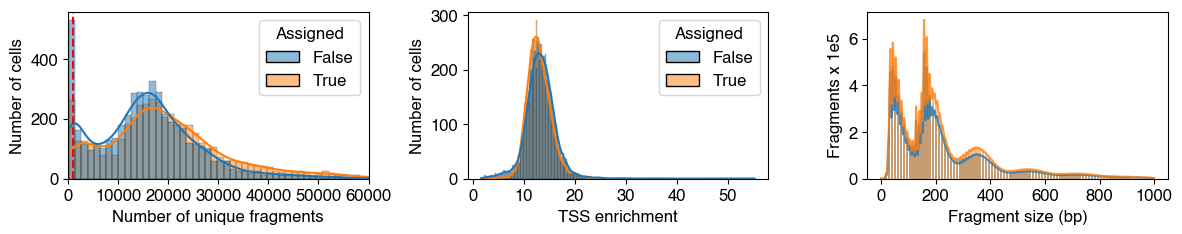

In [3]:
gexqc_047 = cut_qc_metrics_by_called("Lane2_047", savefig = 'outs/S3f_047_gexqc_DOWNSAMPLED.pdf', downsampled=True)
atacqc_047 = cut_qc_metrics_by_called("Lane2_047", mode = 'atac', savefig = 'outs/S3g_047_gexqc_DOWNSAMPLED.pdf', downsampled=True)
qc047 = gexqc_047.join(atacqc_047.drop(["n_guides", "Assigned"], axis = 1), how = 'inner')
qc047.n_fragment = qc047.n_fragment.astype(int)

In [42]:
singlets_040 = qc040.query("n_guides == 1 and log1p_total_counts > 6 and log1p_n_genes_by_counts > 6 and n_fragment > 1000")
singlets_047 = qc047.query("n_guides == 1 and log1p_total_counts > 6 and log1p_n_genes_by_counts > 6 and n_fragment > 1000")

In [45]:
ids_040 = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_outs/Lane1_040_called_ids.csv")
ids_040['n_guides'] = ids_040.groupby('CB').UMI.transform('count')
ids_040 = ids_040.query('n_guides == 1')
ids_040['guide_target'] = ids_040['identity'].map(lambda s: s.split("_")[0] + ("_" + str(s.split("_")[1]) if str(s.split("_")[1]).isdigit() else ""))
ids_040['CB'] = ids_040.CB.map(lambda b: b + "-1")
ids_040.set_index('CB', inplace = True)

ids_047 = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_downsampled/Lane2_047_called_ids.csv")
ids_047['n_guides'] = ids_047.groupby('CB').UMI.transform('count')
ids_047 = ids_047.query('n_guides == 1')
ids_047['guide_target'] = ids_047['identity'].map(lambda s: s.split("_")[0] + ("_" + str(s.split("_")[1]) if str(s.split("_")[1]).isdigit() else ""))
ids_047['CB'] = ids_047.CB.map(lambda b: b + "-1")
ids_047.set_index('CB', inplace = True)

singlets_040 = singlets_040.join(ids_040['guide_target'], how = 'left')
singlets_047 = singlets_047.join(ids_047['guide_target'], how = 'left')

rep_040 = singlets_040.guide_target.value_counts().to_frame("+SIRLOIN/TSO")
rep_047 = singlets_047.guide_target.value_counts().to_frame("-SIRLOIN/TSO")
rep = pd.concat([rep_040, rep_047], axis = 1)

In [10]:
def get_guide_reads(fastq_file, lib):

    guide_reads = []
    with open(fastq_file) as fastq:
        for title, seq, qual in tqdm(FastqGeneralIterator(fastq_file)):
            if np.mean([ord(c) - 33 for c in qual]) >= 30 and str(seq).find('GTTTAAGAGC') != -1:
                guide_reads.append(str(seq).partition('GTTTAAGAGC')[0][-20:])
    colname = f"reads_{lib}"
    return pd.DataFrame({lib: guide_reads}).value_counts().to_frame(colname).rename_axis("protospacer").reset_index().set_index("protospacer")

In [11]:
df_040 = get_guide_reads("/data/norman/eli/T7/202404_SIRLOIN_multiome/library_QC/040-epi16libQC_S1_L001_R1_001.fastq", "040_lib")
df_047 = get_guide_reads("/data/norman/eli/T7/202404_SIRLOIN_multiome/library_QC/047-epi16libQC_S2_L001_R1_001.fastq", "047_lib")
df_reads = pd.concat([df_040, df_047], axis = 1)
guides = pd.read_csv('/data/norman/eli/T7/202404_SIRLOIN_multiome/library_QC/epi16_library_build.csv',index_col = 0)
guides = guides.join(df_reads, how = 'inner')

df_dist = guides[["target_gene", "reads_040_lib", "reads_047_lib"]].copy()
df_dist[['pct_040', 'pct_047']] = 100 * df_dist.filter(like='reads') / df_dist.filter(like='reads').sum()

414148it [00:05, 71563.60it/s]
246939it [00:03, 73254.53it/s]


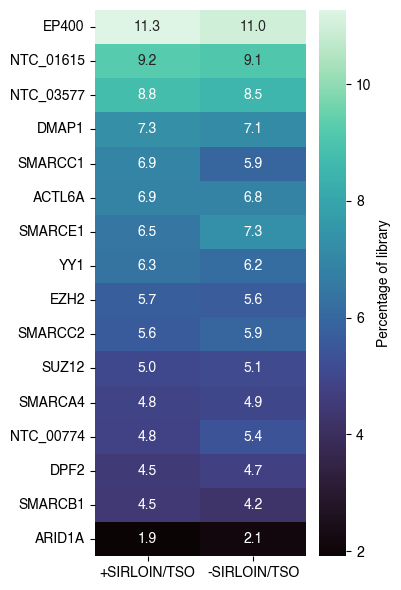

In [28]:
plt.rcParams['font.family'] = 'Helvetica'
df_plot = df_dist.reset_index().set_index("target_gene").filter(like='pct').rename(dict(pct_040 = '+SIRLOIN/TSO', pct_047 = '-SIRLOIN/TSO'), axis = 1).sort_values("+SIRLOIN/TSO", ascending = False)

plt.figure(figsize = (4,6))
sns.heatmap(df_plot, annot=True, cmap = 'mako', cbar_kws={'label': 'Percentage of library'}, fmt = '.1f')
plt.yticks(rotation = 0)
plt.ylabel("")
plt.tight_layout()
# plt.savefig("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/supplementary_outs/FigS3b_library_composition.pdf")
plt.show()

2024-10-14 10:51:39 - INFO - maxp pruned
2024-10-14 10:51:39 - INFO - cmap pruned
2024-10-14 10:51:39 - INFO - post pruned
2024-10-14 10:51:39 - INFO - FFTM dropped
2024-10-14 10:51:39 - INFO - GPOS pruned
2024-10-14 10:51:39 - INFO - GSUB pruned
2024-10-14 10:51:39 - INFO - name pruned
2024-10-14 10:51:39 - INFO - glyf pruned
2024-10-14 10:51:39 - INFO - Added gid0 to subset
2024-10-14 10:51:39 - INFO - Added first four glyphs to subset
2024-10-14 10:51:39 - INFO - Closing glyph list over 'GSUB': 54 glyphs before
2024-10-14 10:51:39 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'plus', 'r', 's', 'seven', 'six', 'slash', 'space', 't', 'three', 'two', 'u', 'underscore', 'uni0008', 'zero']
2024-10-14 10:51:39 - INFO - Glyph IDs:   [0, 1, 2, 3, 5, 16, 18, 20, 21, 22, 23,

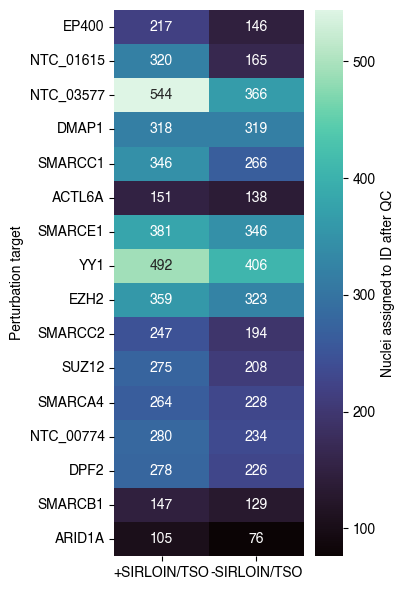

In [47]:
plt.rcParams['font.family'] = 'Helvetica'
plt.figure(figsize = (4,6))
sns.heatmap(rep.loc[['EP400',
 'NTC_01615',
 'NTC_03577',
 'DMAP1',
 'SMARCC1',
 'ACTL6A',
 'SMARCE1',
 'YY1',
 'EZH2',
 'SMARCC2',
 'SUZ12',
 'SMARCA4',
 'NTC_00774',
 'DPF2',
 'SMARCB1',
 'ARID1A'],:], annot=True, fmt = 'd', cmap = 'mako', cbar_kws={'label': 'Nuclei assigned to ID after QC'})
plt.ylabel("Perturbation target")
plt.tight_layout()
plt.savefig("outs/S4a_cellnumbers.pdf")
plt.show()

In [21]:
### Table Sxx filtering

def count_cells_by_filter(gexqc, atacqc):
    print(f"Total cells: {len(gexqc)}")
    print(f"Guide singlets: {len(gexqc.query('n_guides == 1'))}")
    print(f">6 log1p UMI: {len(gexqc.query('n_guides == 1').query('log1p_total_counts > 6'))}")
    print(f">6 log1p unique genes: {len(gexqc.query('n_guides == 1').query('log1p_total_counts > 6').query('log1p_n_genes_by_counts > 6'))}")

    qc = gexqc.query('n_guides == 1').query('log1p_total_counts > 6').query('log1p_n_genes_by_counts > 6').join(atacqc['n_fragment'], how = 'left')
    print(f">1000 ATAC fragments: {len(qc.query('n_fragment > 1000'))}")

In [22]:
count_cells_by_filter(gexqc_040, atacqc_040)

Total cells: 9318
Guide singlets: 4969
>6 log1p UMI: 4968
>6 log1p unique genes: 4965
>1000 ATAC fragments: 4724


In [33]:
count_cells_by_filter(gexqc_047, atacqc_047)

Total cells: 9503
Guide singlets: 3997
>6 log1p UMI: 3996
>6 log1p unique genes: 3993
>1000 ATAC fragments: 3770


In [49]:
rep.sum()

+SIRLOIN/TSO    4724
-SIRLOIN/TSO    3770
dtype: int64